In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import pingouin as pg
import seaborn as sns
from scipy.optimize import least_squares
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import pearsonr,sem, spearmanr

class PsychometricFit(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.slope_ = None
        self.threshold_ = None
        self.popt_ = None
        self.r_squared_ = None

    def _sigmoid(self, x, x0, k, L=1, b=0):
        return L / (1 + np.exp(-k * (x - x0))) + b

    def _residuals(self, params, x, y):
        return y - self._sigmoid(x, *params)

    def fit(self, X, y):
        initial_guess = [np.median(X), 1.0, 1.0, 0.0]
        bounds = (
            [0, 0, 0, -1],
            [1, 500, 1, 1]
        )
        result = least_squares(self._residuals, initial_guess, bounds=bounds, args=(X, y))
        self.popt_ = result.x
        self.threshold_ = result.x[0]
        self.slope_ = result.x[1]

        residuals = y - self._sigmoid(X, *result.x)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        self.r_squared_ = 1 - (ss_res / ss_tot)
        return self

    def predict(self, X):
        return self._sigmoid(X, *self.popt_)

    @property
    def slope(self):
        return self.slope_

    @property
    def threshold(self):
        return self.threshold_

    @property
    def r_squared(self):
        return self.r_squared_

    def summary_dataframe(self):
        data = {
            'slope': [self.slope_],
            'threshold': [self.threshold_],
            'x0': [self.popt_[0]],
            'k': [self.popt_[1]],
            'L': [self.popt_[2]],
            'b': [self.popt_[3]],
            'r_squared': [self.r_squared_]
        }
        return pd.DataFrame(data)


plt.rcParams['xtick.bottom'] = True  # Show ticks at the bottom of the x-axis
plt.rcParams['xtick.top'] = True     # Show ticks at the top of the x-axis
plt.rcParams['ytick.left'] = True    # Show ticks on the left side of the y-axis
plt.rcParams['ytick.right'] = True   # Show ticks on the right side of the y-axis


plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

In [12]:
intensities_real = np.array([0,50,150,300,500]) # all shock intensities
intensities_real_norm = intensities_real/500

# Direct Emotional Response

In [13]:
aversive_zpsize_avg = pd.read_csv('Data/fig_1_2_3/aversive_pupil_zscore.csv',header=[0,1],index_col=[0])
aversive_zpsize_avg.columns = aversive_zpsize_avg.columns.map(lambda x: tuple(map(int, x)))
aversive_vel1_avg = pd.read_csv('Data/fig_1_2_3/aversive_vel_zscore.csv',header=[0,1],index_col=[0])
aversive_vel1_avg.columns = aversive_vel1_avg.columns.map(lambda x: tuple(map(int, x)))
aversive_sub_folder = pd.read_csv('Data/aversive_sub_folder.csv')

aversive_zpsize_avg_diff = (aversive_zpsize_avg.T - aversive_zpsize_avg.xs(0,level=1,axis=1).mean(axis=1).T).T
aversive_vel1_avg_diff = (aversive_vel1_avg.T - aversive_vel1_avg.xs(0,level=1,axis=1).mean(axis=1).T).T

ylims = dict(pupil=(-20,80),velocity=(-60,350))
xlims = [aversive_zpsize_avg_diff.index[0],aversive_zpsize_avg_diff.index[-1]]

## Fig. 1 B,C,D

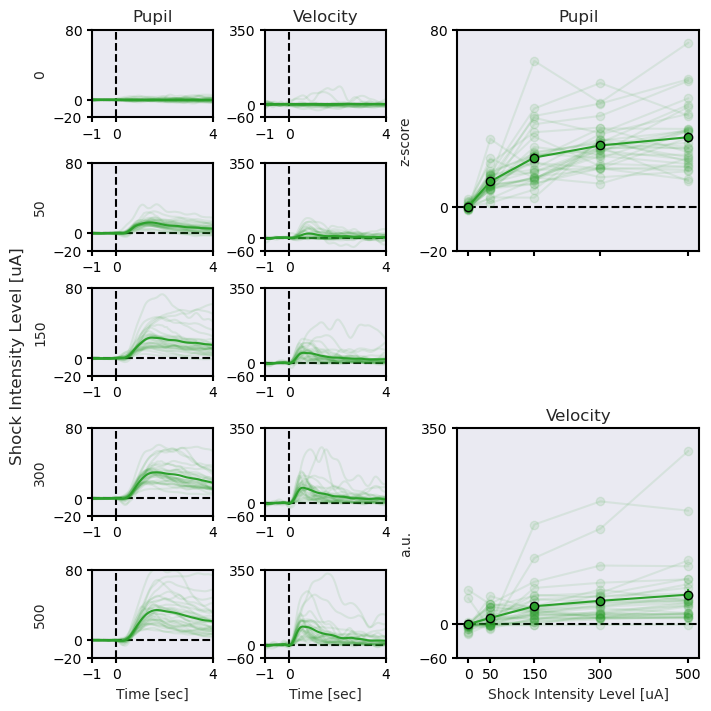

In [14]:
fig = plt.figure(layout="constrained",figsize=(7,7))

gs = GridSpec(5, 4, figure=fig)
ax_pup = dict()
ax_vel = dict()
ax_pup_peaks = fig.add_subplot(gs[0:2, 2:])
ax_vel_peaks = fig.add_subplot(gs[3:, 2:])

fig.supylabel('Shock Intensity Level [uA]')
levels = np.unique([i[1] for i in aversive_zpsize_avg_diff.columns])
for i in levels:
    ax_pup[i] = fig.add_subplot(gs[i, 0])
    ax_vel[i] = fig.add_subplot(gs[i, 1])

    ax_pup[i].axhline(0,color='k',linestyle='--')
    ax_pup[i].axvline(0,color='k',linestyle='--')
    ax_pup[i].plot(aversive_zpsize_avg_diff.xs(i,level=1,axis=1), alpha=0.1,color='tab:green')
    ax_pup[i].plot(aversive_zpsize_avg_diff.xs(i,level=1,axis=1).mean(axis=1),color='tab:green')
    #ax_pup[i].set_ylim([-5,25])

    ax_vel[i].axhline(0,color='k',linestyle='--')
    ax_vel[i].axvline(0,color='k',linestyle='--')
    ax_vel[i].plot(aversive_vel1_avg_diff.xs(i,level=1,axis=1), alpha=0.1,color='tab:green')
    ax_vel[i].plot(aversive_vel1_avg_diff.xs(i,level=1,axis=1).mean(axis=1),color='tab:green')
    #ax_vel[i].set_ylim([-70,70])

    ax_pup[i].set_ylabel(str(intensities_real[i]) ) #+ ' uA'\n z-score' )
    if i == 0:
        ax_pup[i].set_title('Pupil')
        ax_vel[i].set_title('Velocity')

    if i == np.max(levels):
        ax_pup[i].set_xlabel('Time [sec]')
        ax_vel[i].set_xlabel('Time [sec]')
    ax_pup[i].grid(False)
    ax_vel[i].grid(False)
    ax_pup[i].set_xlim([aversive_zpsize_avg_diff.index[0], aversive_zpsize_avg_diff.index[-1]])
    ax_vel[i].set_xlim([aversive_vel1_avg_diff.index[0], aversive_vel1_avg_diff.index[-1]])
    ax_vel[i].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
    ax_pup[i].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
    ax_pup[i].set_ylim(ylims['pupil'])
    ax_vel[i].set_ylim(ylims['velocity'])
    ax_pup[i].set_yticks([ylims['pupil'][0],0,ylims['pupil'][1]])
    ax_vel[i].set_yticks([ylims['velocity'][0], 0,ylims['velocity'][1]])

    ax_pup[i].set_xlim([xlims[0],np.floor(xlims[1])])
    ax_vel[i].set_xlim([xlims[0],np.floor(xlims[1])])
    ax_pup[i].set_xticks([xlims[0],0,np.floor(xlims[1])])
    ax_vel[i].set_xticks([xlims[0], 0,np.floor(xlims[1])])

aversive_psize_curve = aversive_zpsize_avg_diff.loc[1:2].mean().reset_index()
aversive_psize_curve['intensity'] = aversive_psize_curve['intensity'].apply(lambda x: intensities_real[x])
for su in aversive_psize_curve['sub'].unique():
    temp_sub = aversive_psize_curve[aversive_psize_curve['sub']==su]
    ax_pup_peaks.errorbar( temp_sub['intensity'], temp_sub[0], color='tab:green', marker='o', markerfacecolor='tab:green', linestyle='-',markeredgecolor=None, alpha=.1 )
aversive_psize_curve_avg = aversive_psize_curve.groupby('intensity').mean().reset_index()
aversive_psize_curve_sem = aversive_psize_curve.groupby('intensity').sem().reset_index()
ax_pup_peaks.errorbar( aversive_psize_curve_avg['intensity'], aversive_psize_curve_avg[0], yerr=aversive_psize_curve_sem[0], color='tab:green', marker='o', markerfacecolor='tab:green', linestyle='-',markeredgecolor='k', alpha=1 )
ax_pup_peaks.axhline(y=0, color='k',linestyle='--')
ax_pup_peaks.set_ylabel('z-score')
ax_pup_peaks.set_title('Pupil')
#ax_pup_peaks.set_xlabel('Shock Intensity Level [uA]')
ax_pup_peaks.grid(False)
ax_pup_peaks.set_xticks(intensities_real[levels])
ax_pup_peaks.set_xticklabels([])
ax_pup_peaks.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
ax_pup_peaks.set_yticks([ylims['pupil'][0],0,ylims['pupil'][1]])

aversive_vel_curve = aversive_vel1_avg_diff.loc[1:2].mean().reset_index()
aversive_vel_curve['intensity'] = aversive_vel_curve['intensity'].apply(lambda x: intensities_real[x])
for su in aversive_vel_curve['sub'].unique():
    temp_sub = aversive_vel_curve[aversive_vel_curve['sub']==su]
    ax_vel_peaks.errorbar( temp_sub['intensity'], temp_sub[0], color='tab:green', marker='o', markerfacecolor='tab:green', linestyle='-',markeredgecolor=None, alpha=.1 )
#ax_vel_peaks.errorbar( eco_vel_curve['intensity'], eco_vel_curve[0], color='tab:blue', marker='o', markerfacecolor='tab:blue', linestyle='-',markeredgecolor=None, alpha=.1 )
aversive_vel_curve_avg = aversive_vel_curve.groupby('intensity').mean().reset_index()
aversive_vel_curve_sem = aversive_vel_curve.groupby('intensity').sem().reset_index()
ax_vel_peaks.errorbar( aversive_vel_curve_avg['intensity'], aversive_vel_curve_avg[0], yerr=aversive_vel_curve_sem[0], color='tab:green', marker='o', markerfacecolor='tab:green', linestyle='-',markeredgecolor='k', alpha=1 )
ax_vel_peaks.axhline(y=0, color='k',linestyle='--')
ax_vel_peaks.set_ylabel('a.u.')
ax_vel_peaks.set_title('Velocity')
ax_vel_peaks.set_xlabel('Shock Intensity Level [uA]')
ax_vel_peaks.grid(False)
ax_vel_peaks.set_xticks(intensities_real[levels])
ax_vel_peaks.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)


ax_vel_peaks.set_yticks([ylims['velocity'][0], 0,ylims['velocity'][1]])

In [15]:
EC_anova = pg.rm_anova(data=aversive_psize_curve.rename(columns={0:'value'}), dv='value', within='intensity',
                       subject='sub',
                       )
EC_anova.insert(0,'Test','anova_rm')
EC_anova.insert(1,'N', aversive_psize_curve['sub'].unique().size)
EC_post_hoc = pg.pairwise_tests(data=aversive_psize_curve.rename(columns={0:'value'}), dv='value', within='intensity',
                                subject='sub', padjust='fdr_bh').sort_values(by='p-corr')
EC_post_hoc['signi']=''
EC_post_hoc['signi'] = EC_post_hoc['p-corr'].apply(lambda x: '***' if x<0.001 else '**' if x<0.01 else '*' if x<0.05 else '')
EC_post_hoc.insert(0,'Test','anova_rm_post_hoc')
EC_all_stats = pd.concat([EC_anova,EC_post_hoc.drop('signi',axis=1)])

print('Pupil Statistics:')
EC_all_stats

Pupil Statistics:


,Test,N,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,...,B,Paired,Parametric,T,dof,alternative,p-corr,p-adjust,BF10,hedges
0,anova_rm,32.0,intensity,4.0,124.0,76.358821,1.609301e-32,1.569751e-20,0.571989,0.601973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,6.650445e-16,NaN,NaN,NaN,...,300,True,True,-15.183308,31.0,two-sided,6.650445e-15,fdr_bh,8.858e+12,-3.826420
3,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,2.678235e-13,NaN,NaN,NaN,...,500,True,True,-12.122536,31.0,two-sided,1.339118e-12,fdr_bh,2.835e+10,-3.029837
0,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,1.073377e-12,NaN,NaN,NaN,...,50,True,True,-11.480724,31.0,two-sided,3.577923e-12,fdr_bh,7.533e+09,-2.836457
1,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,6.223729e-11,NaN,NaN,NaN,...,150,True,True,-9.724169,31.0,two-sided,1.555932e-10,fdr_bh,1.58e+08,-2.389493
5,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,1.428251e-09,NaN,NaN,NaN,...,300,True,True,-8.474006,31.0,two-sided,2.856503e-09,fdr_bh,8.125e+06,-1.990113
6,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,2.520807e-08,NaN,NaN,NaN,...,500,True,True,-7.392929,31.0,two-sided,4.201346e-08,fdr_bh,5.443e+05,-1.811990
4,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,4.423216e-05,NaN,NaN,NaN,...,150,True,True,-4.747528,31.0,two-sided,6.318880e-05,fdr_bh,536.859,-1.076683
8,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,8.769009e-05,NaN,NaN,NaN,...,500,True,True,-4.507278,31.0,two-sided,1.096126e-04,fdr_bh,288.371,-0.663716
7,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,3.224013e-03,NaN,NaN,NaN,...,300,True,True,-3.192870,31.0,two-sided,3.582237e-03,fdr_bh,11.657,-0.467270


In [16]:
EC_anova = pg.rm_anova(data=aversive_vel_curve.rename(columns={0:'value'}), dv='value', within='intensity',
                       subject='sub',
                       )
EC_anova.insert(0,'Test','anova_rm')
EC_anova.insert(1,'N', aversive_vel_curve['sub'].unique().size)
EC_post_hoc = pg.pairwise_tests(data=aversive_vel_curve.rename(columns={0:'value'}), dv='value', within='intensity',
                                subject='sub', padjust='fdr_bh').sort_values(by='p-corr')
EC_post_hoc['signi']=''
EC_post_hoc['signi'] = EC_post_hoc['p-corr'].apply(lambda x: '***' if x<0.001 else '**' if x<0.01 else '*' if x<0.05 else '')
EC_post_hoc.insert(0,'Test','anova_rm_post_hoc')
EC_all_stats = pd.concat([EC_anova,EC_post_hoc.drop('signi',axis=1)])
print('Locomotor Statistics:')
EC_all_stats

Locomotor Statistics:


,Test,N,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,...,B,Paired,Parametric,T,dof,alternative,p-corr,p-adjust,BF10,hedges
0,anova_rm,32.0,intensity,4.0,124.0,17.885607,1.287218e-11,0.000014,0.201526,0.367759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,6.056544e-06,NaN,NaN,NaN,...,300,True,True,-5.441408,31.0,two-sided,0.000032,fdr_bh,3315.843,-1.196980
3,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,6.485683e-06,NaN,NaN,NaN,...,500,True,True,-5.417531,31.0,two-sided,0.000032,fdr_bh,3113.346,-1.164985
1,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,1.666638e-05,NaN,NaN,NaN,...,150,True,True,-5.088476,31.0,two-sided,0.000056,fdr_bh,1308.928,-1.144195
7,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,5.373668e-04,NaN,NaN,NaN,...,300,True,True,-3.860583,31.0,two-sided,0.001343,fdr_bh,56.516,-0.228102
6,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,8.754189e-04,NaN,NaN,NaN,...,500,True,True,-3.682437,31.0,two-sided,0.001751,fdr_bh,36.628,-0.916521
5,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,1.330242e-03,NaN,NaN,NaN,...,300,True,True,-3.527738,31.0,two-sided,0.002217,fdr_bh,25.305,-0.872877
8,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,2.042442e-03,NaN,NaN,NaN,...,500,True,True,-3.366967,31.0,two-sided,0.002918,fdr_bh,17.362,-0.404796
0,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,5.582054e-03,NaN,NaN,NaN,...,50,True,True,-2.978674,31.0,two-sided,0.006202,fdr_bh,7.252,-0.716171
4,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,5.512164e-03,NaN,NaN,NaN,...,150,True,True,-2.983658,31.0,two-sided,0.006202,fdr_bh,7.331,-0.741333


## Fig. 1 E

9;27;28;

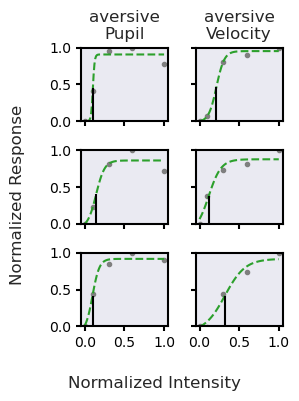

In [17]:

aversive_zpsize_avg_pnt = aversive_zpsize_avg_diff.loc[0:].mean().unstack()
aversive_vel1_avg_pnt = aversive_vel1_avg_diff.loc[0:].mean().unstack()

fig,ax = plt.subplots(3,2,figsize=(3,4),sharey=True,sharex=True)
fig.supylabel('Normalized Response')
fig.supxlabel('Normalized Intensity')
a = 0
for i in range(aversive_zpsize_avg_pnt.shape[0]):
    if i in [9,27,28]:
        print(i,end=';')
        ladder = aversive_zpsize_avg_pnt.loc[i,:]
        x_values = (np.array([0,50,150,300,500])/500)
        y_values = (ladder.values-ladder.values[0])/np.max(ladder.values-ladder.values[0])
        psych_aversive_zpsize = PsychometricFit()
        psych_aversive_zpsize.fit(x_values,y_values)
        x_pred = np.linspace(0,max(x_values),100)
        y_pred = psych_aversive_zpsize.predict(x_pred)
        ax[a,0].plot(x_values, y_values, markersize=3,color='tab:gray',marker='o',linestyle='None')
        ax[a,0].plot(x_pred, y_pred, color='tab:green',linestyle='--')
        lims = ax[a,0].get_ylim()
        ax[a,0].vlines(psych_aversive_zpsize.threshold,color='k',linestyle='-', ymax=psych_aversive_zpsize.predict(psych_aversive_zpsize.threshold), ymin=-0.05)
        ax[a,0].grid(False)

        ladder = aversive_vel1_avg_pnt.loc[i,:]
        x_values = (np.array([0,50,150,300,500])/500)
        y_values = (ladder.values-ladder.values[0])/np.max(ladder.values-ladder.values[0])
        psych_aversive_vel1 = PsychometricFit()
        psych_aversive_vel1.fit(x_values,y_values)
        x_pred = np.linspace(0,max(x_values),100)
        y_pred = psych_aversive_vel1.predict(x_pred)
        ax[a,1].plot(x_values, y_values, markersize=3,color='tab:gray',marker='o',linestyle='None')
        ax[a,1].plot(x_pred, y_pred, color='tab:green',linestyle='--')
        lims = ax[a,1].get_ylim()
        ax[a,1].vlines(psych_aversive_vel1.threshold,color='k',linestyle='-', ymax=psych_aversive_vel1.predict(psych_aversive_vel1.threshold), ymin=-0.05)
        ax[a,1].grid(False)

        ax[a,0].set_yticks([0,0.5,1])
        ax[a,0].set_xticks([0,0.5,1])
        ax[a,0].set_ylim([0,1])
        if a==0:
            ax[a,0].set_title('aversive\nPupil')
            ax[a,1].set_title('aversive\nVelocity')
            #ax[a,2].set_title('CONTAGION\nPupil')

        ax[a,0].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
        ax[a,1].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
        #ax[a,2].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

        a+=1


plt.tight_layout()

## Fig. 1 F

In [18]:
aversive_zpsize_avg_pnt = aversive_zpsize_avg_diff.loc[0:].mean().unstack()
aversive_vel1_avg_pnt = aversive_vel1_avg_diff.loc[0:].mean().unstack()


msize = 3
fit_res = list()

for i in range(aversive_zpsize_avg_pnt.shape[0]):
    print(i,end=';')
    ladder = aversive_zpsize_avg_pnt.loc[i,:]
    x_values = (np.array([0,50,150,300,500])/500)
    y_values = (ladder.values-ladder.values[0])/np.max(ladder.values-ladder.values[0])
    psych_aversive_zpsize = PsychometricFit()
    psych_aversive_zpsize.fit(x_values,y_values)


    ladder = aversive_vel1_avg_pnt.loc[i,:]
    x_values = (np.array([0,50,150,300,500])/500)
    y_values = (ladder.values-ladder.values[0])/np.max(ladder.values-ladder.values[0])
    psych_aversive_vel1 = PsychometricFit()
    psych_aversive_vel1.fit(x_values,y_values)
    

    temp = pd.concat([psych_aversive_zpsize.summary_dataframe().add_prefix('pp_'),
                      psych_aversive_vel1.summary_dataframe().add_prefix('pv_')],axis=1)
    temp.index=[i]
    fit_res.append(temp)


fit_res = pd.concat(fit_res)


0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,what,n
T-test,-0.714988,62,two-sided,0.477300,"[-0.07, 0.03]",0.178747,0.317,0.108420,r2,32.0
T-test,-1.261871,62,two-sided,0.211722,"[-0.14, 0.03]",0.315468,0.5,0.237186,thresh,NaN


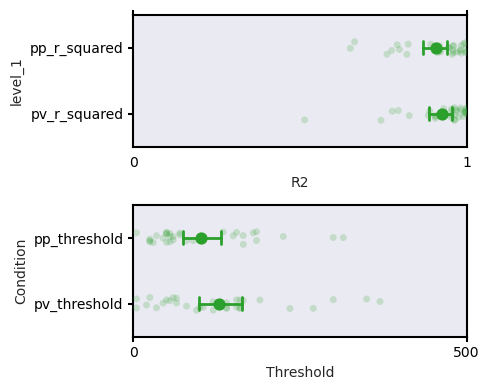

In [19]:
gof_level = -1
x_data = fit_res[['pp_threshold']][fit_res['pp_r_squared']>gof_level].values*500
y_data = fit_res[['pv_threshold']][fit_res['pp_r_squared']>gof_level].values*500

fig,ax = plt.subplots(2,1, figsize=(5,4))

r2_stacked = fit_res[['pp_r_squared','pv_r_squared']].rename(columns={'pain_pupil_r_square':'PAIN\npupil','pain_vel1_r_square':'PAIN\nvelocity'}).stack().reset_index()
r2_stacked = r2_stacked.rename(columns={0:'R2'})
sns.stripplot(data=r2_stacked,x='R2', y='level_1',hue='level_1',alpha=.2,ax=ax[0],palette=['tab:green','tab:green'],legend=False)
sns.pointplot(data=r2_stacked,x='R2',  y='level_1', hue='level_1',alpha=1,linestyle='None',ax=ax[0],capsize=0.2, err_kws={'linewidth':2},palette=['tab:green','tab:green'],legend=False)
ax[0].grid(False)

per_kde = fit_res[(fit_res['pp_r_squared']>gof_level)&(fit_res['pv_r_squared']>gof_level)][['pp_threshold','pv_threshold']].stack().reset_index().rename(columns={'level_1':'Condition',0:'Threshold','level_0':'intensity'})
per_kde['Threshold'] = (per_kde['Threshold']).round(2)*500
sns.stripplot(per_kde,x='Threshold', y='Condition', hue='Condition', color='tab:blue', ax=ax[1],alpha=0.2,palette=['tab:green','tab:green'])
sns.pointplot(per_kde,x='Threshold', y='Condition', hue='Condition', color='tab:blue', ax=ax[1],linestyle='None',alpha=1,capsize=0.2, err_kws={'linewidth':2},palette=['tab:green','tab:green'])
#ax[0,1].legend().remove()
ax[1].grid(False)

ax[0].tick_params(axis='both', which='both', bottom=False, top=True, left=True, right=False)
ax[1].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

xlims = [0,1]
ax[0].set_xlim(np.round(xlims))
ax[0].set_xticks([0,np.round(xlims[1])])

xlims = [0,500]
ax[1].set_xlim(np.round(xlims))
ax[1].set_xticks([0,np.round(xlims[1])])

plt.tight_layout()
stats_r2 = pg.ttest(fit_res['pp_r_squared'],fit_res['pv_r_squared'])
stats_r2['what'] = 'r2'
stats_r2['n'] = fit_res['pp_r_squared'].size
stats_thresh = pg.ttest(fit_res['pp_threshold'],fit_res['pv_threshold'])
stats_thresh['what'] = 'thresh'

pd.concat([stats_r2,stats_thresh])

# Fig. 1 G

rho: 0.3541055718475073 - pval:0.04676932787943166


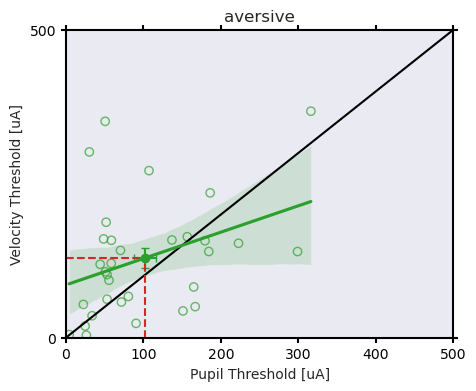

In [20]:
x_data = fit_res[['pp_threshold']][fit_res['pp_r_squared']>gof_level].values*500
y_data = fit_res[['pv_threshold']][fit_res['pp_r_squared']>gof_level].values*500

fig,ax = plt.subplots(figsize=(5,4))
ax.axline((1, 1), slope=1,color='k', linestyle='-')
ax.scatter(
    x_data, y_data,alpha=.7,edgecolor='tab:green', facecolor='none'
)
ax.errorbar(x_data.mean(), y_data.mean(), xerr=sem(x_data),yerr=sem(y_data), fmt='o', capsize=3,color='tab:green')
ax.set_xlabel('Pupil Threshold [uA]')
ax.set_ylabel('Velocity Threshold [uA]')
ax.vlines(x=x_data.mean(), ymin=0, ymax=y_data.mean(), colors='tab:red', linestyles='--', label='Vertical Line')
ax.hlines(y=y_data.mean(), xmin=0, xmax=x_data.mean(), colors='tab:red', linestyles='--', label='Vertical Line')
ax.set_title('aversive')
sns.regplot(x=x_data, y=y_data, ax=ax, scatter=False, color='tab:green', line_kws={'label': 'Linear fit'})

ax.grid(False)
corr_coef, p_value = spearmanr(x_data.flatten(), y_data.flatten())

ax.set_xlim([0,500])
ax.set_ylim([0,500])

ylims = ax.get_ylim()
ax.set_ylim(np.round(ylims))
ax.set_yticks([0,np.round(ylims[1])])
print(f"rho: {corr_coef} - pval:{p_value}")